In [1]:
!pip install pyvi
!pip install torch

In [2]:
import os, shutil
import kagglehub

# Download dataset
path = kagglehub.dataset_download("iambestfeeder/10000-vietnamese-books")

# Move or copy to /content
target_dir = "10000-vietnamese-books"
os.makedirs(target_dir, exist_ok=True)
shutil.copytree(path, target_dir, dirs_exist_ok=True)

print("✅ Dataset copied to:", target_dir)
!ls -lh $target_dir

✅ Dataset copied to: 10000-vietnamese-books


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import os
import re
import math
import time
import glob
import random
from pathlib import Path
from collections import Counter
import regex
import pandas as pd
from pyvi import ViTokenizer, ViPosTagger

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
# Regex patterns
RE_EMAIL = re.compile(r"([\w0-9_\.-]+)(@)([\d\w\.-]+)(\.)([\w\.]{2,6})")
RE_URL = re.compile(r"https?:\/\/(?!.*:\/\/)\S+")
RE_PHONE = re.compile(r"(09|01[2|6|8|9])+([0-9]{8})\b")
RE_MENTION = re.compile(r"@.+?:")
RE_NUMBER = re.compile(r"\d+\.?\d*")
RE_DATETIME = '\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}'
RE_HTML_TAG = re.compile(r'<[^>]+>')
RE_CLEAR_1 = regex.compile(r"[^_<>\s\p{Latin}]")  # requires 'regex' library
RE_CLEAR_2 = re.compile(r"__+")
RE_CLEAR_3 = re.compile(r"\s+")

KEEP_DIACRITICS = True # Keep Vietnamese diacritics when lower-casing

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC\AppData\Local\Temp\ipykernel_19812\1988956448.py:7: SyntaxWarning: invalid escape sequence '\d'
  RE_DATETIME = '\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}'


In [5]:
def replace_common_token(txt):
  txt = re.sub(RE_EMAIL, ' ', txt)
  txt = re.sub(RE_URL, ' ', txt)
  txt = re.sub(RE_MENTION, ' ', txt)
  txt = re.sub(RE_DATETIME, ' ', txt)
  txt = re.sub(RE_NUMBER, ' ', txt)
  return txt

def remove_emoji(txt):
    txt = re.sub(r':v', '', txt)
    txt = re.sub(r':D', '', txt)
    txt = re.sub(r':3', '', txt)
    txt = re.sub(r':\(', '', txt)
    txt = re.sub(r':\)', '', txt)
    txt = re.sub(r'=\)*', '', txt)
    return txt

def remove_html_tag(txt):
    return re.sub(RE_HTML_TAG, ' ', txt)

def loaddicchar():
    dic = {}
    char1252 = (
        'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|'
        'è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|'
        'ì|í|ỉ|ĩ|ị|'
        'ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|'
        'ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|'
        'ỳ|ý|ỷ|ỹ|ỵ|'
        'À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|'
        'È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|'
        'Ì|Í|Ỉ|Ĩ|Ị|'
        'Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|'
        'Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|'
        'Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    ).split('|')

    charutf8 = (
        'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|'
        'è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|'
        'ì|í|ỉ|ĩ|ị|'
        'ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|'
        'ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|'
        'ỳ|ý|ỷ|ỹ|ỵ|'
        'À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|'
        'È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|'
        'Ì|Í|Ỉ|Ĩ|Ị|'
        'Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|'
        'Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|'
        'Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    ).split('|')

    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

dicchar = loaddicchar()

def convertwindown1525toutf8(txt):
    """
    Convert Vietnamese text from Windows-1252/VNI encoding errors
    to proper UTF-8 Unicode.
    """
    return re.sub(
        '|'.join(dicchar.keys()),  # regex khớp toàn bộ các ký tự lỗi
        lambda x: dicchar[x.group()],
        txt
    )

In [6]:
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)
        
def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

def chuan_hoa_dau_tu_tieng_viet(word):
    """
    Normalize tone marks in a single Vietnamese word.
    Ensures tone marks are placed on the correct vowel
    according to Vietnamese orthography.
    Example: 'hoà' -> 'hoà', 'thỏai' -> 'thoải', 'úy' -> 'úy'
    """
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0              # tone mark type (sắc, huyền, hỏi, ngã, nặng)
    nguyen_am_index = []     # indexes of vowels in the word
    qu_or_gi = False         # special case flag for "qu" and "gi"

    # Scan each character
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue

        # Special case "qu": treat 'u' after 'q' as a consonant
        if x == 9 and index > 0 and chars[index - 1] == 'q':
            chars[index] = 'u'
            qu_or_gi = True

        # Special case "gi": treat 'i' after 'g' as a consonant
        elif x == 5 and index > 0 and chars[index - 1] == 'g':
            chars[index] = 'i'
            qu_or_gi = True

        # If this vowel has a tone mark → record it
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]  # reset to base vowel

        # Record vowel index unless it's part of "qu"/"gi"
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)

    # Case: no valid vowels
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                # "gi", "qu" cases with 2 letters
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                # longer word with "gi"/"qu"
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    # fallback: put tone on i or u
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    # Case: if the word contains ê or ơ → always put the tone there
    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    # Case: word has 2 vowels
    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            # If last vowel is at the end → tone goes to the first vowel
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            # Otherwise → tone goes to the second vowel
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]

    # Case: word has 3 vowels (e.g., "khuyên")
    else:
        # Place tone on the middle vowel
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]

    return ''.join(chars)

In [7]:
def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        words[index] = chuan_hoa_dau_tu_tieng_viet(word)
    return ' '.join(words)

In [8]:
def preprocess(txt):
    # 1. Remove HTML tags
    txt = remove_html_tag(txt)

    # 2. Remove HTML entities like &nbsp; &amp; ...
    txt = re.sub('&.{3,4};', ' ', txt)

    # 3. Convert Windows-1252/VNI encoding errors to UTF-8
    txt = convertwindown1525toutf8(txt)
    
    # 4. Tokenize Vietnamese text
    txt = ViTokenizer.tokenize(txt)

    # 5. Smart lowercase (POS tagging)
    txt = txt.lower() 
    
    # 6. Remove common tokens (emails, URLs, mentions, dates, numbers, phones)
    txt = replace_common_token(txt)

    # 7. Remove emojis and emoticons
    txt = remove_emoji(txt)

    # 8. Remove unwanted characters
    txt = RE_CLEAR_1.sub(" ", txt)  # non-Latin chars
    txt = RE_CLEAR_2.sub(" ", txt)  # collapse multiple underscores
    txt = RE_CLEAR_3.sub(" ", txt)  # collapse multiple spaces

    # 9. Normalize Vietnamese diacritics
    txt = chuan_hoa_dau_tu_tieng_viet(txt)
    
    # 10. Strip leading/trailing whitespace
    return txt.strip()

In [9]:
from tqdm import tqdm
import os

data_path = "10000-vietnamese-books/output"
data = []

# Wrap file iteration with tqdm
for file_name in tqdm(os.listdir(data_path), desc="Reading files"):
    file_path = os.path.join(data_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        # Add inner tqdm for large files (optional)
        for line in f:
            sentences = line.strip().split("\n")
            for sentence in sentences:
                data.append(preprocess(sentence))

Reading files: 100%|██████████| 10415/10415 [1:41:36<00:00,  1.71it/s]  


In [10]:
print(f"Total sentences: {len(data)}")
print(f"Sample: {data[5][:100]}")

# Calculate sentence lengths
lengths = [len(text.split()) for text in data if text]

print(f"Total sentences: {len(data)}")
print(f"Average length: {np.mean(lengths):.2f} words")
print(f"Min length: {np.min(lengths)}")
print(f"Max length: {np.max(lengths)}")

Total sentences: 958296
Sample: về yêu hoa_cúc
Total sentences: 958296
Average length: 267.93 words
Min length: 1
Max length: 50404


Total words: 242316831
Unique words: 1003281


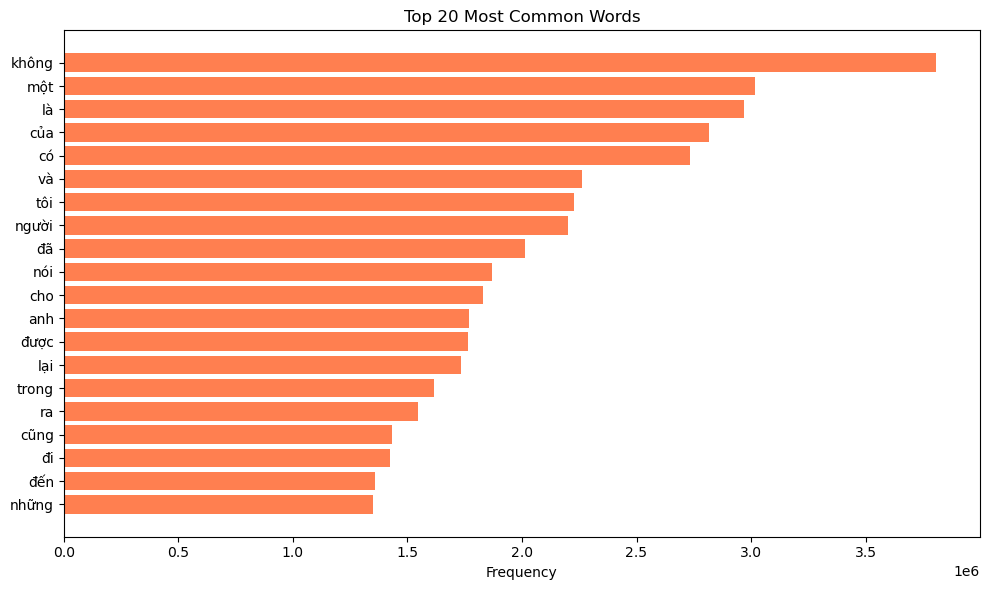

In [11]:
import matplotlib.pyplot as plt

all_words = []
for text in data:
    if text:
        all_words.extend(text.split())
        
word_freq = Counter(all_words)
print(f"Total words: {len(all_words)}")
print(f"Unique words: {len(word_freq)}")

# Top 20 words
top_20 = word_freq.most_common(20)
words, counts = zip(*top_20)

plt.figure(figsize=(10, 6))
plt.barh(range(len(words)), counts, color='coral')
plt.yticks(range(len(words)), words)
plt.gca().invert_yaxis()
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.tight_layout()
plt.show()

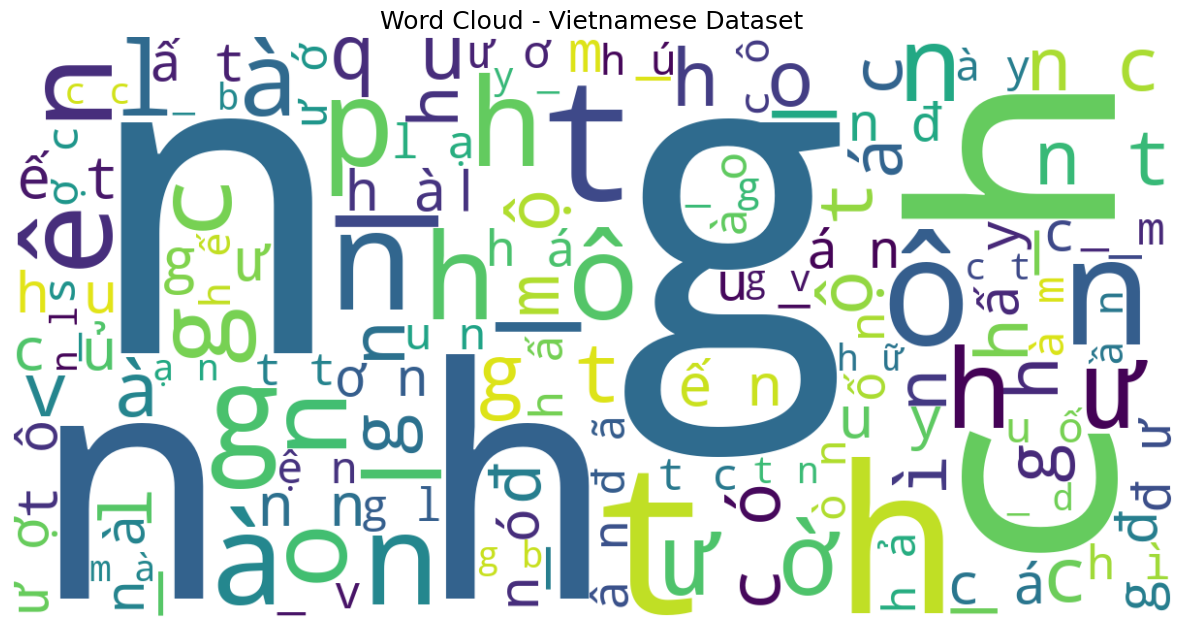

In [12]:
from wordcloud import WordCloud

sample_text = ' '.join(data[:50000])

word_cloud = WordCloud(width=1200, height=600,
                       background_color='white',
                       max_words=100,
                       colormap='viridis').generate(' '.join(sample_text))

plt.figure(figsize=(15, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Vietnamese Dataset', fontsize=18)
plt.show()

In [13]:
import pickle

# Config
MAX_VOCAB_SIZE = 20000
SEQUENCE_LENGTH = 50

# Filter empty sentences
data_clean = [text for text in data if text and len(text.strip()) > 0]
print(f"Clean sentences: {len(data_clean)}")

# Build vocabulary
all_words = []
for text in data_clean:
    all_words.extend(text.split())
    
word_counts = Counter(all_words)
most_common = word_counts.most_common(MAX_VOCAB_SIZE - 2)

# Create word2idx and idx2word
word2idx = {'<PAD>': 0, '<UNK>': 1}
idx2word = {0: '<PAD>', 1: '<UNK>'}

for idx, (word, count) in enumerate(most_common, start=2):
    word2idx[word] = idx
    idx2word[idx] = word
    
vocab_size = len(word2idx)
print(f"Vocabulary size: {vocab_size}")

# Save vocabulary
vocab_data = {'word2idx': word2idx, 'idx2word': idx2word}
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)
    
print("Vocabulary saved!")

Clean sentences: 904407
Vocabulary size: 20000
Vocabulary saved!


In [14]:
def text_to_ids(text):
    """Convert text to numbers"""
    return [word2idx.get(word, word2idx['<UNK>']) for word in text.split()]

X_list = []
y_list = []

stride = SEQUENCE_LENGTH // 2

print("Creating sequences...")
for text in tqdm(data[:100000]):
    ids = text_to_ids(text)
    
    if len(ids) < SEQUENCE_LENGTH + 1:
        continue
    
    # Sliding windows
    for i in range(0, len(ids) - SEQUENCE_LENGTH, stride):
        if i + SEQUENCE_LENGTH >= len(ids):
            break
        
        X_list.append(ids[i:i+SEQUENCE_LENGTH])
        y_list.append(ids[i + SEQUENCE_LENGTH])
        
X = np.array(X_list)
y = np.array(y_list)

print(f"✅ Created {len(X):,} sequences")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Creating sequences...


100%|██████████| 100000/100000 [00:19<00:00, 5138.30it/s]


✅ Created 766,627 sequences
X shape: (766627, 50)
y shape: (766627,)


In [15]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [16]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    
dataset = TextDataset(X, y)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
print(f"Data ready! {len(dataset):,} samples")

Data ready! 766,627 samples


In [17]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        
        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2,
                            batch_first=True, dropout=0.3)
        
        # Output layers
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, vocab_size)
        
    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embed(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Create model
model = LSTMModel(vocab_size, embed_dim=128, hidden_dim=256)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"✅ LSTM Model created!")
print(f"Parameters: {total_params }")
print(model)

✅ LSTM Model created!
Parameters: 6094496
LSTMModel(
  (embed): Embedding(20000, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=20000, bias=True)
)


In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
EPOCHS = 20

losses = []
accs = []

print("Training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Stats
        total_loss += loss.item()
        _, pred = torch.max(out, 1)
        correct += (pred == y_batch).sum().item()
        total += y_batch.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.3f}', 
                         'acc': f'{100*correct/total:.1f}%'})
        
    avg_loss = total_loss / len(loader)
    acc = 100 * correct/total
    losses.append(avg_loss)
    accs.append(acc)
    
    print(f"Epoch {epoch+1}: Loss={avg_loss:.3f}, Acc={acc:.3f}")
    
    # Save best
    if epoch == 0 or avg_loss < min(losses[:-1]):
        torch.save(model.state_dict, 'best_model.pth')
        print('✅ Saved!')
        
print("\n✅ Training done!")

Training...


Epoch 1/20: 100%|██████████| 2995/2995 [43:07<00:00,  1.16it/s, loss=6.820, acc=3.6%] 


Epoch 1: Loss=7.120, Acc=3.595
✅ Saved!


Epoch 2/20: 100%|██████████| 2995/2995 [43:29<00:00,  1.15it/s, loss=6.608, acc=5.4%] 


Epoch 2: Loss=6.751, Acc=5.360
✅ Saved!


Epoch 3/20: 100%|██████████| 2995/2995 [43:00<00:00,  1.16it/s, loss=6.309, acc=6.4%]


Epoch 3: Loss=6.539, Acc=6.430
✅ Saved!


Epoch 4/20: 100%|██████████| 2995/2995 [42:49<00:00,  1.17it/s, loss=6.480, acc=7.2%]


Epoch 4: Loss=6.386, Acc=7.200
✅ Saved!


Epoch 5/20: 100%|██████████| 2995/2995 [5:02:24<00:00,  6.06s/it, loss=5.988, acc=7.7%]       


Epoch 5: Loss=6.267, Acc=7.724
✅ Saved!


Epoch 6/20:   6%|▌         | 179/2995 [43:38<11:26:31, 14.63s/it, loss=6.088, acc=8.2%]  


KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(losses, marker='o', linewidth=2)
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.grid(True, alpha=0.3)

ax2.plot(accs, marker='o', linewidth=2, color='green')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('%')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training.png', dpi=200)
plt.show()

In [ ]:
print("\n" + "="*60)
print("💾 LOAD MODEL LATER")
print("="*60)

with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
    word2idx = vocab['word2idx']
    idx2word = vocab['idx2word']
    
# Load model
vocab_size = len(word2idx)
model = LSTMModel(vocab_size, embed_dim=128, hidden_dim=256)
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
model.eval()

In [ ]:
def generate(seed, num_words=30, temp=1.0):
    """Generate text from seed"""
    model.eval()
    
    ids = text_to_ids(seed)
    
    with torch.no_grad():
        for _ in range(num_words):
            # Take last SEQUENCE_LENGTH tokens
            x = ids[-SEQUENCE_LENGTH:]
            if len(x) < SEQUENCE_LENGTH:
                x = [0] * (SEQUENCE_LENGTH - len(x)) + x
                
            # Predict
            x = torch.LongTensor([x]).to(device)
            out = model(x)[0]
            
            # Apply temperature
            out = out / temp
            probs = torch.softmax(out, dim=0).cpu().numpy()
            
            # Sample
            next_id = np.random.choice(len(probs), p=probs)
            ids.append(next_id)
            
    # Decode
    words = [idx2word.get(i, '') for i in ids]
    return ' '.join(words)

In [ ]:
seeds = ["tôi đang", "cuộc sống", "ngày mai"]

for seed in seeds:
    print(f"\n🌱 Seed: '{seed}'")
    print("-" * 60)
    
    seed = preprocess(seed)
    
    # Different temperatures
    for temp in [0.7, 1.0, 1.3]:
        result = generate(seed, num_words=25, temp=temp)
        print(f"Temp {temp}: {result}")